## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [24]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Data Load

In [25]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_16.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_16.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

Total_train = pd.read_csv('train_eda_code_14.csv')
Total_test = pd.read_csv('test_eda_code_14.csv')

In [26]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

### 인코딩 

In [27]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "착상_전_유전_검사_사용_여부",
    "남성_주_불임_원인",
    "남성_부_불임_원인",
    "여성_주_불임_원인",
    "여성_부_불임_원인",
    "부부_주_불임_원인",
    "부부_부_불임_원인",
    "불명확_불임_원인",
    "불임_원인_-_난관_질환",
    "불임_원인_-_남성_요인",
    "불임_원인_-_배란_장애",
    "불임_원인_-_여성_요인",
    "불임_원인_-_자궁경부_문제",
    "불임_원인_-_자궁내막증",
    "불임_원인_-_정자_농도",
    "불임_원인_-_정자_면역학적_요인",
    "불임_원인_-_정자_운동성",
    "불임_원인_-_정자_형태",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]

In [28]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [29]:
Total_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "단일_배아_이식_여부",
    "착상_전_유전_검사_사용_여부",
    "착상_전_유전_진단_사용_여부",
    "배아_생성_주요_이유",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "총_생성_배아_수",
    "미세주입된_난자_수",
    "미세주입에서_생성된_배아_수",
    "이식된_배아_수",
    "미세주입_배아_이식_수",
    "저장된_배아_수",
    "미세주입_후_저장된_배아_수",
    "해동된_배아_수",
    "해동_난자_수",
    "수집된_신선_난자_수",
    "저장된_신선_난자_수",
    "혼합된_난자_수",
    "파트너_정자와_혼합된_난자_수",
    "기증자_정자와_혼합된_난자_수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]

In [30]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])
Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

In [39]:
# import category_encoders as ce

# # 모든 범주형 변수를 문자열로 변환
# IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
# DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
# IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
# DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# # 타겟 인코더를 사용하여 범주형 변수 인코딩
# IVF_target_encoder = ce.TargetEncoder(cols=IVF_categorical_columns)
# DI_target_encoder = ce.TargetEncoder(cols=DI_categorical_columns)

# # 타겟 인코딩을 위해 타겟 변수가 필요합니다. 예시로 IVF_y와 DI_y를 사용합니다.
# IVF_X[IVF_categorical_columns] = IVF_target_encoder.fit_transform(IVF_X[IVF_categorical_columns], IVF_y)
# DI_X[DI_categorical_columns] = DI_target_encoder.fit_transform(DI_X[DI_categorical_columns], DI_y)
# IVF_test[IVF_categorical_columns] = IVF_target_encoder.transform(IVF_test[IVF_categorical_columns])
# DI_test[DI_categorical_columns] = DI_target_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [31]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)
Total_X_train, Total_X_test, Total_y_train, Total_y_test = train_test_split(Total_X, Total_y, test_size=0.2, random_state=42)


--- Model Performance ---
Model Accuracy: 0.7452960348723281
Model F1 Score: 0.20137931034482756
Model AUC: 0.740092007499688


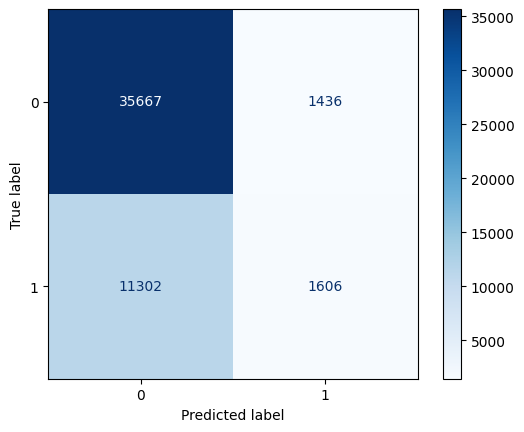

In [32]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=2532,
    num_leaves=2016,
    max_depth=5,
    learning_rate=0.017499436870417804,
    min_child_samples=93,
    subsample=0.7626939046359561,
    colsample_bytree=0.7237639819602849,
    reg_alpha=0.0851602459056204,
    reg_lambda=71.84045497686223,
    min_split_gain=0.23831656711494814,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
    )

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7120085190039318


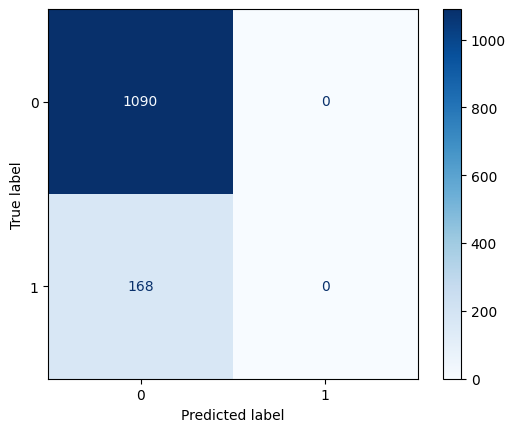

In [33]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=1171,
    num_leaves=1352,
    max_depth=133,
    learning_rate=0.013047268869340142,
    min_child_samples=165,
    subsample=0.24314691590400292,
    colsample_bytree=0.19334614890476431,
    reg_alpha=5.901900488743287,
    reg_lambda=3.858355492244645e-05,
    min_split_gain=0.00045035353026440803,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7482689344438159
Model F1 Score: 0.19928030773048763
Model AUC: 0.7417351100014749


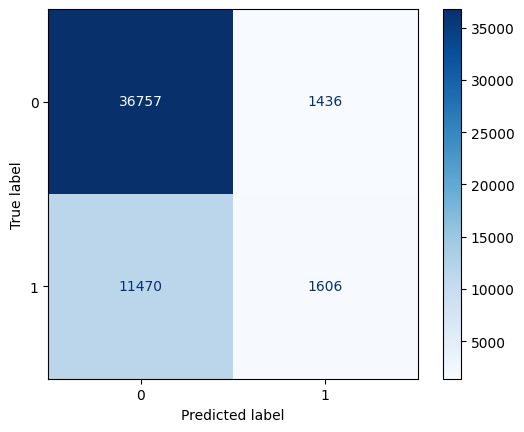

In [34]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Total 데이터 사용시


--- Model Performance ---
Model Accuracy: 0.7438218026487741
Model F1 Score: 0.1893593383532897
Model AUC: 0.7382604133776007


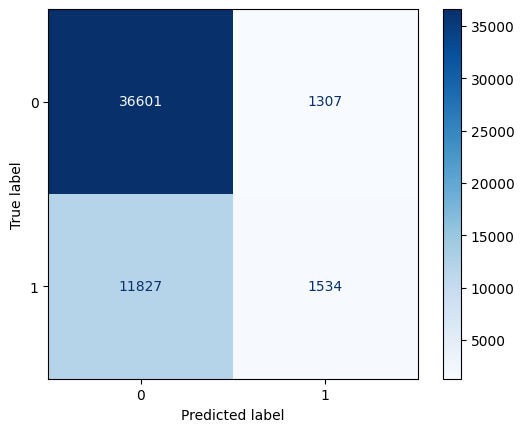

In [35]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 초기화
Total_model = lgb.LGBMClassifier(
    n_estimators=2347,
    num_leaves=50,
    max_depth=142,
    learning_rate=0.021188216439538957,
    min_child_samples=182,
    subsample=0.7951918621697477,
    colsample_bytree=0.33700062509197354,
    reg_alpha=0.10020567478518366,
    reg_lambda=8.52283471798228e-05,
    min_split_gain=0.3800055047800433,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
Total_model.fit(Total_X_train, Total_y_train)

# 예측
y_pred = Total_model.predict(Total_X_test)
y_pred_proba = Total_model.predict_proba(Total_X_test)[:, 1]

# 평가
accuracy = accuracy_score(Total_y_test, y_pred)
f1 = f1_score(Total_y_test, y_pred)
auc = roc_auc_score(Total_y_test, y_pred_proba)
cm = confusion_matrix(Total_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Total_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

분할모델 & Total 모델 소프트보팅


--- Model Performance ---
Model Accuracy: 0.7451091302736547
Model F1 Score: 0.03925893250992501
Model AUC: 0.670819044620319


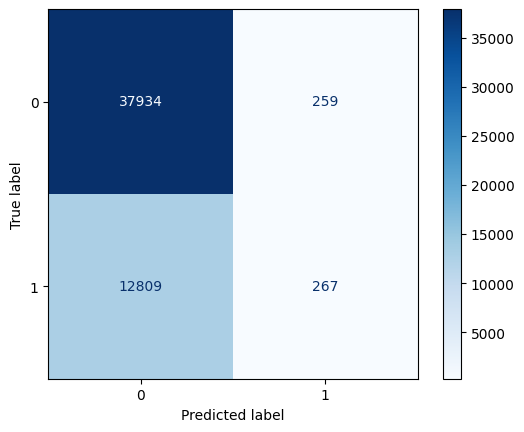

In [37]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# 첫 번째 모델 초기화 (IVF와 DI 모델 병합)
IVF_model = lgb.LGBMClassifier(
    n_estimators=2532,
    num_leaves=2016,
    max_depth=5,
    learning_rate=0.017499436870417804,
    min_child_samples=93,
    subsample=0.7626939046359561,
    colsample_bytree=0.7237639819602849,
    reg_alpha=0.0851602459056204,
    reg_lambda=71.84045497686223,
    min_split_gain=0.23831656711494814,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

DI_model = lgb.LGBMClassifier(
    n_estimators=1171,
    num_leaves=1352,
    max_depth=133,
    learning_rate=0.013047268869340142,
    min_child_samples=165,
    subsample=0.24314691590400292,
    colsample_bytree=0.19334614890476431,
    reg_alpha=5.901900488743287,
    reg_lambda=3.858355492244645e-05,
    min_split_gain=0.00045035353026440803,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 두 번째 모델 초기화 (Total 모델)
Total_model = lgb.LGBMClassifier(
    n_estimators=2347,
    num_leaves=50,
    max_depth=142,
    learning_rate=0.021188216439538957,
    min_child_samples=182,
    subsample=0.7951918621697477,
    colsample_bytree=0.33700062509197354,
    reg_alpha=0.10020567478518366,
    reg_lambda=8.52283471798228e-05,
    min_split_gain=0.3800055047800433,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)
DI_model.fit(DI_X_train, DI_y_train)
Total_model.fit(Total_X_train, Total_y_train)

# 예측
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
IVF_y_pred = IVF_model.predict(IVF_X_test)
DI_y_pred = DI_model.predict(DI_X_test)

y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# Total 모델의 예측 확률
Total_y_pred_proba = Total_model.predict_proba(Total_X_test)[:, 1]

# 소프트 보팅
y_pred_proba_combined = (y_pred_proba + Total_y_pred_proba) / 2
y_pred_combined = (y_pred_proba_combined >= 0.5).astype(int)

# 평가
accuracy = accuracy_score(y_test, y_pred_combined)
f1 = f1_score(y_test, y_pred_combined)
auc = roc_auc_score(y_test, y_pred_proba_combined)
cm = confusion_matrix(y_test, y_pred_combined)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [44]:
# 모델 구축
# IVF_model = CatBoostClassifier(
#     iterations=680,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# DI_model = CatBoostClassifier(
#     iterations=500,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [45]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('./code15_submit.csv', index=False, encoding='utf-8')

.